## Simulated credit card transactions - Exploratory Data Analysis

This is a simulated credit card transaction dataset with legitimate and fraud transactions in 2019 and 2020. It was sourced from Kaggle https://www.kaggle.com/datasets/kartik2112/fraud-detection?resource=download&select=fraudTrain.csv

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (
    create_timestamp_columns, 
    plot_comparison_histogram
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initial questions after loading in the data
- How many samples are there? How many belong to the majority class (not fraud) and minority class (fraud)? What kind of oversampling methods (e.g. SMOTE) can we use to handle this imbalance?
- What are the numerical and categorical features?
- What are the distributions of the numerical features like? How do we handle missing values?

In [74]:
filepath = 'data/fraudTrain.csv'
df = pd.read_csv(filepath)

In [75]:
# quick overview of the data columns that we have
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [76]:
# how unbalanced is the training set?
n_samples = len(df)
print(f'Num samples: {n_samples}')
df['is_fraud'].value_counts(normalize=True) # 99.4% of samples are not fraud

Num samples: 1296675


is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [77]:
# Convert datetime string to datetime format
# Extract relevant quantities such as the hour and weekday of the transaction
# Engineer new features such as time since last transaction
df = create_timestamp_columns(df)
#
# Split into fraud and non-fraud cases for analysis
df_normal = df.loc[df['is_fraud']==0]
df_fraud = df.loc[df['is_fraud']==1]

## Transaction amount
- Do unusually large or small payment amounts indicate fraud? 
- Examine the distribution of transaction amounts for both fraud and non-fraud cases

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'Normal'}, xlabel='Transaction amount', ylabel='Frequency'>,
        <Axes: title={'center': 'Fraud'}, xlabel='Transaction amount', ylabel='Frequency'>],
       dtype=object))

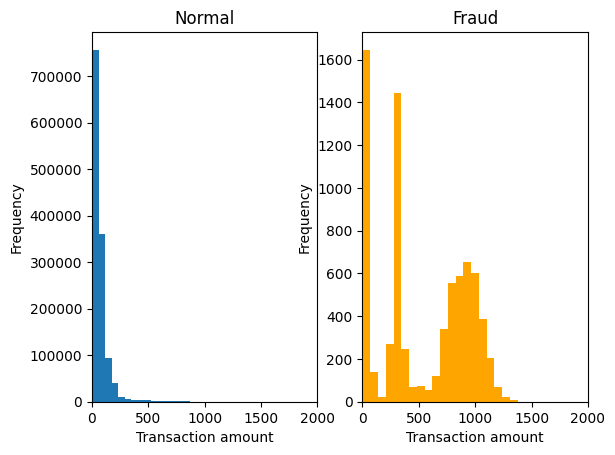

In [78]:
plot_comparison_histogram(
    df_normal, 
    df_fraud, 
    col_name='amt', 
    normal_bins=500, 
    max_x=2000, 
    x_label='Transaction amount', 
    y_label='Frequency'
)

In [79]:
# helper function to compute summary statistics of a numerical column
def print_summary_stats(col: pd.Series, is_fraud: bool = False) -> None:
    print(f"""
    Summary statistics for {col.name},{is_fraud=}
    mean: {col.mean()}
    median: {col.median()}
    skewness: {col.skew()}
    """)

In [10]:
print_summary_stats(df_fraud['amt'], is_fraud=True)
print_summary_stats(df_normal['amt'], is_fraud=False)


    Summary statistics for amt,is_fraud=True
    mean: 531.3200919264589
    median: 396.505
    skewness: 0.02584608402403506
    

    Summary statistics for amt,is_fraud=False
    mean: 67.6671098126002
    median: 47.28
    skewness: 47.523765335989694
    


Distribution of normal transactions is positively skewed and very roughly in the shape of an exponential distribution. The distribution of fraudulent transactions is multi-modal, with modes at very small values and just under 1000. On average fraudulent transactions have a larger mean/median.

## Transaction category
- What are the different transaction categories?
- Is there a statistically significance difference in the proportion of certain kinds of categories for the fraud and non-fraud cases?
- Can we one-hot encode this data?

In [51]:
df_normal['category'].value_counts(normalize=True)

category
gas_transport     0.101648
home              0.095346
grocery_pos       0.094553
shopping_pos      0.089848
kids_pets         0.087495
shopping_net      0.074335
entertainment     0.072745
food_dining       0.070829
personal_care     0.070230
health_fitness    0.066513
misc_pos          0.061594
misc_net          0.048382
grocery_net       0.035153
travel            0.031331
Name: proportion, dtype: float64

In [ ]:
df_fraud['category'].value_counts(normalize=True)

category
grocery_pos       0.232214
shopping_net      0.228217
misc_net          0.121902
shopping_pos      0.112310
gas_transport     0.082334
misc_pos          0.033307
kids_pets         0.031841
entertainment     0.031042
personal_care     0.029310
home              0.026379
food_dining       0.020117
grocery_net       0.017852
health_fitness    0.017719
travel            0.015454
Name: proportion, dtype: float64

It seems like among fraudulent transactions, the proportion of in-person grocery (```grocery_pos```) and online shopping (```shopping_net```) are higher in a statistically significant way. We can confirm this for (e.g. online shopping) using a two-proportion z-test as follows. We find that the corresponding p-value is effectively 0, meaning that there is a statistically significant difference.

In [ ]:
# null hypothesis (H_o): online shopping transactions not more likely for fraudulent than non-fraudulent transactions
# Given data
x1, n1 = len(df_normal[df_normal['category']=='shopping_net']), len(df_normal)  # Number of 'shopping_net' transactions and total transactions in non-fraudulent group
x2, n2 = len(df_fraud[df_fraud['category']=='shopping_net']), len(df_fraud)  # Number of 'shopping_net' transactions and total transactions in fraudulent group

# Compute proportions
p1, p2 = x1 / n1, x2 / n2
p_pooled = (x1 + x2) / (n1 + n2)

# Compute standard error and z-score
SE = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
z_score = (p1 - p2) / SE

print(f"Z-score: {z_score:.2f}")
# the p value is effectively zero, so we reject the null hypothesis. There is a statistically significant difference.

Z-score: -50.40


Text(0.5, 1.0, 'Transaction amount by category, grouped by fraud vs non-fraud samples')

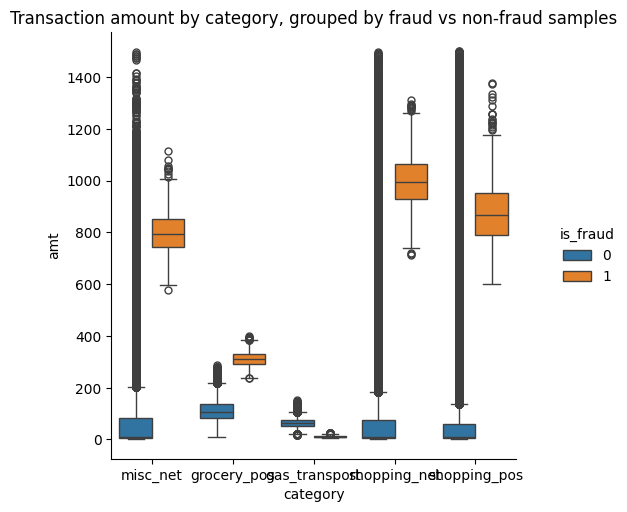

In [27]:
# isolate some categories that are more potentially prone to fraud
high_risk_categories = ['grocery_pos', 'shopping_net', 'misc_net', 'shopping_pos', 'gas_transport']
ax = sns.catplot(
    data=df[(df['category'].isin(high_risk_categories)) & (df['amt'] < 1500)], 
    x='category', 
    y='amt', 
    hue='is_fraud',
    kind='box'
)
plt.title('Transaction amount by category, grouped by fraud vs non-fraud samples')

### Timestamp

- Do fraudsters have a tendency to strike at unusual hours?
- Can we engineer features based on timestamp? These might include:
- Transaction frequency by the same cardholder
- Time since last transaction
- Encoding timestamp information as cyclical features e.g. morning/night/hour of transaction


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'Normal'}, xlabel='Transaction hour', ylabel='Frequency'>,
        <Axes: title={'center': 'Fraud'}, xlabel='Transaction hour', ylabel='Frequency'>],
       dtype=object))

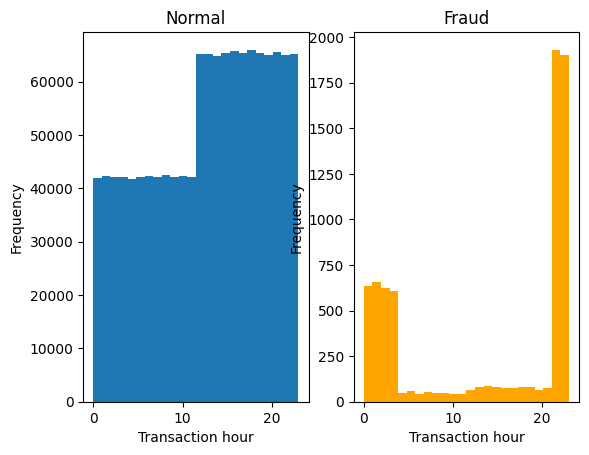

In [80]:
plot_comparison_histogram(
    df_normal, 
    df_fraud, 
    col_name='hour', 
    normal_bins=24,
    fraud_bins=24, 
    x_label='Transaction hour', 
    y_label='Frequency'
)

Given that a transaction is fraudulent, the probability that it is at hours late in the night (22, 23, - 3am) is more likely.

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'Normal'}, xlabel='Time since last transaction (minutes)', ylabel='Frequency'>,
        <Axes: title={'center': 'Fraud'}, xlabel='Time since last transaction (minutes)', ylabel='Frequency'>],
       dtype=object))

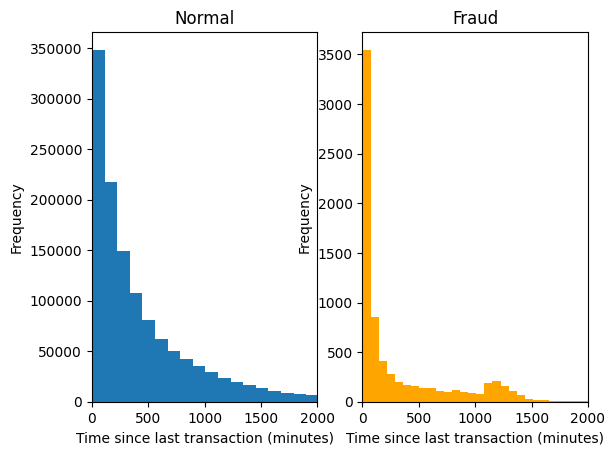

In [81]:
# Time since last transaction - one of our engineered features
plot_comparison_histogram(
    df_normal, 
    df_fraud, 
    max_x = 2000,
    normal_bins=200,
    fraud_bins=200,
    col_name='time_since_last_minutes', 
    x_label='Time since last transaction (minutes)', 
    y_label='Frequency'
)

In [72]:
print_summary_stats(df_fraud['time_since_last_minutes'], is_fraud=True)
print_summary_stats(df_normal['time_since_last_minutes'], is_fraud=False)


    Summary statistics for time_since_last_minutes,is_fraud=True
    mean: 355.39437715874936
    median: 81.8
    skewness: 5.5890440623519515
    

    Summary statistics for time_since_last_minutes,is_fraud=False
    mean: 542.4899443772135
    median: 277.05
    skewness: 4.273382265952385
    


In general, fraudulent transactions occur between shorter intervals, as summarised by the above. There is also a small irregular peak at around 1100 minutes, where there is a higher concentration of fraudulent transactions. This potentially indicates that some fraudsters make transactions at regular intervals (e.g. using a computer)